# We'll analyze the StackOverflow developer survey dataset. 
## Stack Overflow is a question and answer site for professional and enthusiast programmers.
### The dataset contains responses to an annual survey conducted by StackOverflow. You can find the raw data & official analysis here: https://insights.stackoverflow.com/survey.

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv('stack-overflow-survey/2020 Stack Overflow Survey Responses.csv', index_col='Respondent')
raw_data[:5]

,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
Respondent,,,,,,,,,,,,,,,,,,,,,
1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,EUR,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,GBP,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,ALL,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64461 entries, 1 to 65112
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   MainBranch                    64162 non-null  object 
 1   Hobbyist                      64416 non-null  object 
 2   Age                           45446 non-null  float64
 3   Age1stCode                    57900 non-null  object 
 4   CompFreq                      40069 non-null  object 
 5   CompTotal                     34826 non-null  float64
 6   ConvertedComp                 34756 non-null  float64
 7   Country                       64072 non-null  object 
 8   CurrencyDesc                  45472 non-null  object 
 9   CurrencySymbol                45472 non-null  object 
 10  DatabaseDesireNextYear        44070 non-null  object 
 11  DatabaseWorkedWith            49537 non-null  object 
 12  DevType                       49370 non-null  object 
 13  E

In [4]:
schema_raw = pd.read_csv('stack-overflow-survey/survey results schema 2020.csv', index_col='Column').QuestionText

In [5]:
schema_raw['YearsCode']

'Including any education, how many years have you been coding in total?'

### We can refer to the schema file to see the full text of each question.

## Data  preparation and cleaning
We'll limit our analysis to the following areas:
- Distribution of programming skills, experience, and preferences
- Employment-related information, preferences, and opinions</br>

Let's select a subset of columns with the relevant data for our analysis.

In [6]:
selected_columns = [
    # Demographics
    'Country',
    'Age',
    'Gender',
    'EdLevel',
    'UndergradMajor',
    # Programming experience
    'Hobbyist',
    'Age1stCode',
    'YearsCode',
    'YearsCodePro',
    'LanguageWorkedWith',
    'LanguageDesireNextYear',
    # Employment
    'Employment',
    'DevType',
    'WorkWeekHrs',
    'JobSat',
    'JobFactors',
    'NEWOvertime',
    'NEWEdImpt'
]

data = raw_data[selected_columns].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64461 entries, 1 to 65112
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 64072 non-null  object 
 1   Age                     45446 non-null  float64
 2   Gender                  50557 non-null  object 
 3   EdLevel                 57431 non-null  object 
 4   UndergradMajor          50995 non-null  object 
 5   Hobbyist                64416 non-null  object 
 6   Age1stCode              57900 non-null  object 
 7   YearsCode               57684 non-null  object 
 8   YearsCodePro            46349 non-null  object 
 9   LanguageWorkedWith      57378 non-null  object 
 10  LanguageDesireNextYear  54113 non-null  object 
 11  Employment              63854 non-null  object 
 12  DevType                 49370 non-null  object 
 13  WorkWeekHrs             41151 non-null  float64
 14  JobSat                  45194 non-null

Most columns have the data type `object`, because they contain values of different types. It appears that every column contains some empty values since the Non-Null count for every column is lower than the total number of rows (64461).To make our analysis easier, let's convert some other columns into numeric data types while ignoring any non-numeric value. 

In [7]:
data.YearsCode.unique()

array(['36', '7', '4', '15', '6', '17', '8', '10', '35', '5', '37', '19',
       '9', '22', '30', '23', '20', '2', 'Less than 1 year', '3', '13',
       '25', '16', '43', '11', '38', '33', nan, '24', '21', '12', '40',
       '27', '50', '46', '14', '18', '28', '32', '44', '26', '42', '31',
       '34', '29', '1', '39', '41', '45', 'More than 50 years', '47',
       '49', '48'], dtype=object)

### Changing columns to numeric, values which cannot be changed to numeric are set to NaN

In [8]:
data['Age1stCode'] = pd.to_numeric(data.Age1stCode, errors='coerce')
data['YearsCode'] = pd.to_numeric(data.YearsCode, errors='coerce')
data['YearsCodePro'] = pd.to_numeric(data.YearsCodePro, errors='coerce')

In [9]:
data.describe()

,Age,Age1stCode,YearsCode,YearsCodePro,WorkWeekHrs
count,45446.000000,57473.000000,56784.000000,44133.000000,41151.000000
mean,30.834111,15.476572,12.782051,8.869667,40.782174
std,9.585392,5.114081,9.490657,7.759961,17.816383
min,1.000000,5.000000,1.000000,1.000000,1.000000
25%,24.000000,12.000000,6.000000,3.000000,40.000000
50%,29.000000,15.000000,10.000000,6.000000,40.000000
75%,35.000000,18.000000,17.000000,12.000000,44.000000
max,279.000000,85.000000,50.000000,50.000000,475.000000


### Droping rows where age is higher than 100 and lower than 10 years
#### There seems to be a problem with the `age` column, as the minimum value is 1 and the maximum is 279.

In [10]:
mask = ((data['Age'] < 16) | (data['Age'] > 100))
data.drop(data[mask].index, inplace=True)

In [11]:
data.describe()

,Age,Age1stCode,YearsCode,YearsCodePro,WorkWeekHrs
count,44994.000000,57031.000000,56359.000000,44117.000000,41134.000000
mean,30.997740,15.518560,12.844532,8.871478,40.781355
std,9.408143,5.105865,9.495629,7.760405,17.804402
min,16.000000,5.000000,1.000000,1.000000,1.000000
25%,24.000000,12.000000,6.000000,3.000000,40.000000
50%,29.000000,15.000000,10.000000,6.000000,40.000000
75%,35.000000,18.000000,17.000000,12.000000,44.000000
max,99.000000,85.000000,50.000000,50.000000,475.000000


#### The same holds for WorkWeekHrs. Let's ignore entries where the value for the column is higher than 140 hours. (~20 hours per day).

In [12]:
mask = ((data['WorkWeekHrs'] > 140 ) | (data['WorkWeekHrs'] < 10 ))
data.drop(data[mask].index, inplace=True)
data['Gender'].value_counts()

Man                                                            44259
Woman                                                           3725
Non-binary, genderqueer, or gender non-conforming                376
Man;Non-binary, genderqueer, or gender non-conforming            118
Woman;Non-binary, genderqueer, or gender non-conforming           91
Woman;Man                                                         66
Woman;Man;Non-binary, genderqueer, or gender non-conforming       25
Name: Gender, dtype: int64

#### The gender column also allows for picking multiple options. We'll remove values containing more than one option to simplify our analysis.

In [13]:
data.where(~(data.Gender.str.contains(';', na=False)), np.nan, inplace=True)

In [14]:
data.sample(10)

,Country,Age,Gender,EdLevel,UndergradMajor,Hobbyist,Age1stCode,YearsCode,YearsCodePro,LanguageWorkedWith,LanguageDesireNextYear,Employment,DevType,WorkWeekHrs,JobSat,JobFactors,NEWOvertime,NEWEdImpt
Respondent,,,,,,,,,,,,,,,,,,
20222,United States,46.0,Man,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Computer science, computer engineering, or sof...",Yes,6.0,40.0,20.0,Dart,Dart,Employed full-time,Product manager,50.0,Very satisfied,"Languages, frameworks, and other technologies ...",Often: 1-2 days per week or more,Fairly important
38017,India,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Another engineering discipline (such as civil,...",Yes,17.0,5.0,NaN,NaN,NaN,"Not employed, but looking for work",Academic researcher,NaN,NaN,NaN,NaN,NaN
5912,Nicaragua,40.0,Man,"Professional degree (JD, MD, etc.)","Information systems, information technology, o...",Yes,18.0,20.0,2.0,HTML/CSS;JavaScript;PHP;SQL,Kotlin;TypeScript,Employed full-time,"Developer, back-end;Developer, front-end;Educator",40.0,Slightly satisfied,Remote work options;Office environment or comp...,Often: 1-2 days per week or more,Very important
28319,Argentina,20.0,Man,Some college/university study without earning ...,"Information systems, information technology, o...",Yes,16.0,4.0,NaN,C;Java;Python,C;C++;Java;Python,Student,NaN,NaN,NaN,"Languages, frameworks, and other technologies ...",NaN,NaN
54226,Australia,24.0,Man,Some college/university study without earning ...,"Computer science, computer engineering, or sof...",Yes,12.0,12.0,7.0,HTML/CSS;Java;JavaScript;Scala;SQL,NaN,"Independent contractor, freelancer, or self-em...","Database administrator;Developer, back-end;Dev...",38.0,Slightly satisfied,Flex time or a flexible schedule;Remote work o...,Often: 1-2 days per week or more,Not at all important/not necessary
5255,Australia,30.0,Man,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...",Yes,18.0,12.0,5.0,JavaScript;Python;SQL,Bash/Shell/PowerShell;Go;JavaScript;Python,Employed full-time,"Academic researcher;Developer, back-end",30.0,Very satisfied,Industry that I’d be working in;Flex time or a...,Never,Fairly important
52814,United States,30.0,NaN,"Associate degree (A.A., A.S., etc.)","Computer science, computer engineering, or sof...",Yes,10.0,10.0,5.0,Bash/Shell/PowerShell;C;C#;HTML/CSS;Java;JavaS...,Bash/Shell/PowerShell;Rust,Employed full-time,"Developer, back-end;Developer, desktop or ente...",40.0,Slightly dissatisfied,"Flex time or a flexible schedule;Languages, fr...",Never,Somewhat important
61579,Brazil,30.0,Man,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Computer science, computer engineering, or sof...",Yes,14.0,10.0,8.0,Bash/Shell/PowerShell;HTML/CSS;JavaScript;PHP;...,Bash/Shell/PowerShell;HTML/CSS;JavaScript;PHP;...,Employed full-time,"Developer, desktop or enterprise applications;...",40.0,Slightly satisfied,Flex time or a flexible schedule;Remote work o...,Occasionally: 1-2 days per quarter but less th...,Very important
42399,Croatia,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Another engineering discipline (such as civil,...",Yes,9.0,20.0,15.0,NaN,NaN,"Independent contractor, freelancer, or self-em...","Designer;Developer, back-end;Developer, deskto...",NaN,NaN,NaN,NaN,Not at all important/not necessary


### Exploratory Analysis and Visualization
#### Before we ask questions about the survey responses, it would help to understand the respondents' demographics, i.e., country, age, gender, education level, employment level, etc. It's essential to explore these variables to understand how representative the survey is of the worldwide programming community.

In [15]:
import seaborn as sns
import matplotlib
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9,5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [16]:
data.Country.nunique()

183

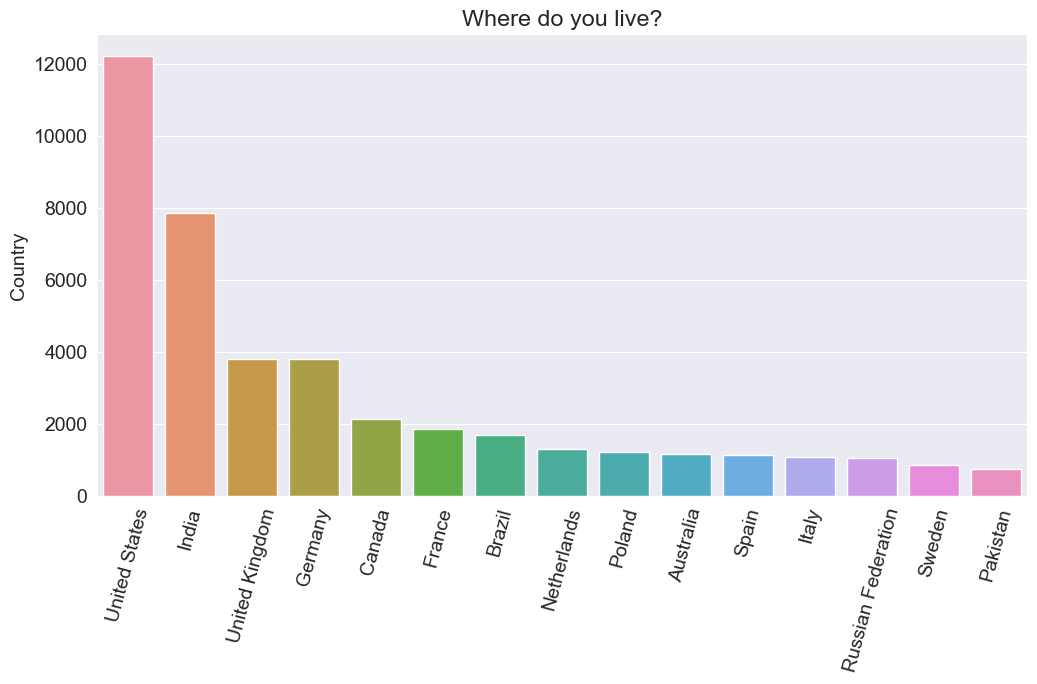

In [17]:
top_countries = data.Country.value_counts().head(15)
plt.figure(figsize=(12,6))
plt.xticks(rotation=75)
plt.title('Where do you live?')
sns.barplot(x = top_countries.index, y = top_countries);

It appears that a disproportionately high number of respondents are from the US and India, probably because the survey is in English, and these countries have the highest English-speaking populations. We can already see that the survey may not be representative of the global programming community - especially from non-English speaking countries.

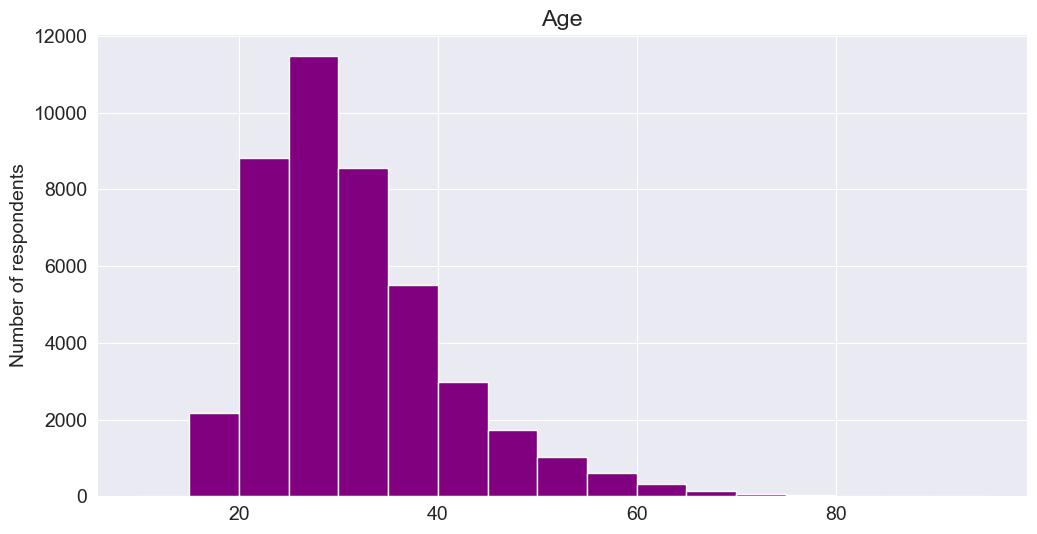

In [18]:
plt.figure(figsize=(12,6))
plt.title('Age')
plt.ylabel('Number of respondents')
plt.hist(data['Age'], bins=np.arange(10,100,5), color='purple');

It appears that a large percentage of respondents are 20-45 years old. People fresh to programing probably use stackoverflow more, because their questions are more likely to be already answered.

In [19]:
bins= [10,18,24,34,44,54,64, 101]
labels = ['Under 18 years old','18-24 years old','25-34 years old','35-44 years old','45-54 years old','55-64 years old','65 years or older']
data['AgeGroup'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

In [20]:
gender_count = data.Gender.value_counts()

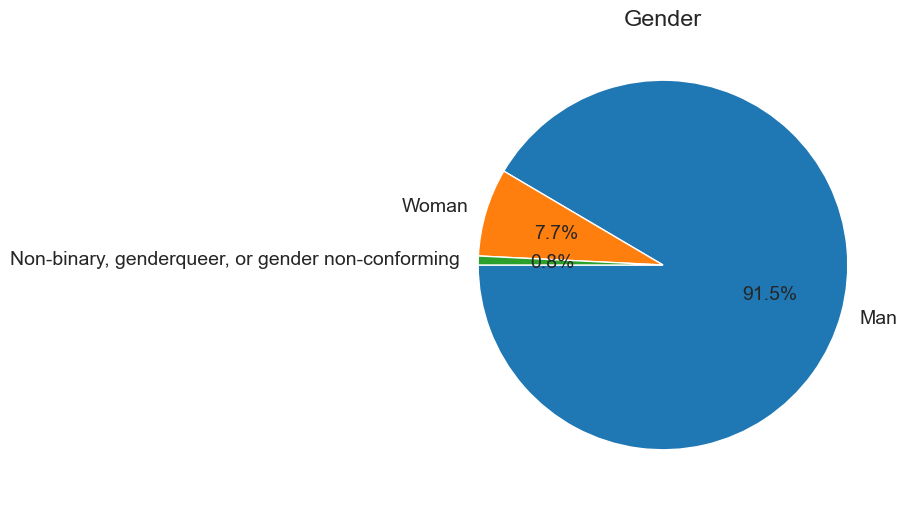

In [21]:
plt.figure(figsize=(12,6))
plt.title('Gender')
plt.pie(gender_count, labels=gender_count.index, autopct='%1.1f%%', startangle=180);

Only about 8% of survey respondents who have answered the question identify as women or non-binary. This number is probably higher in overall programing comunity.

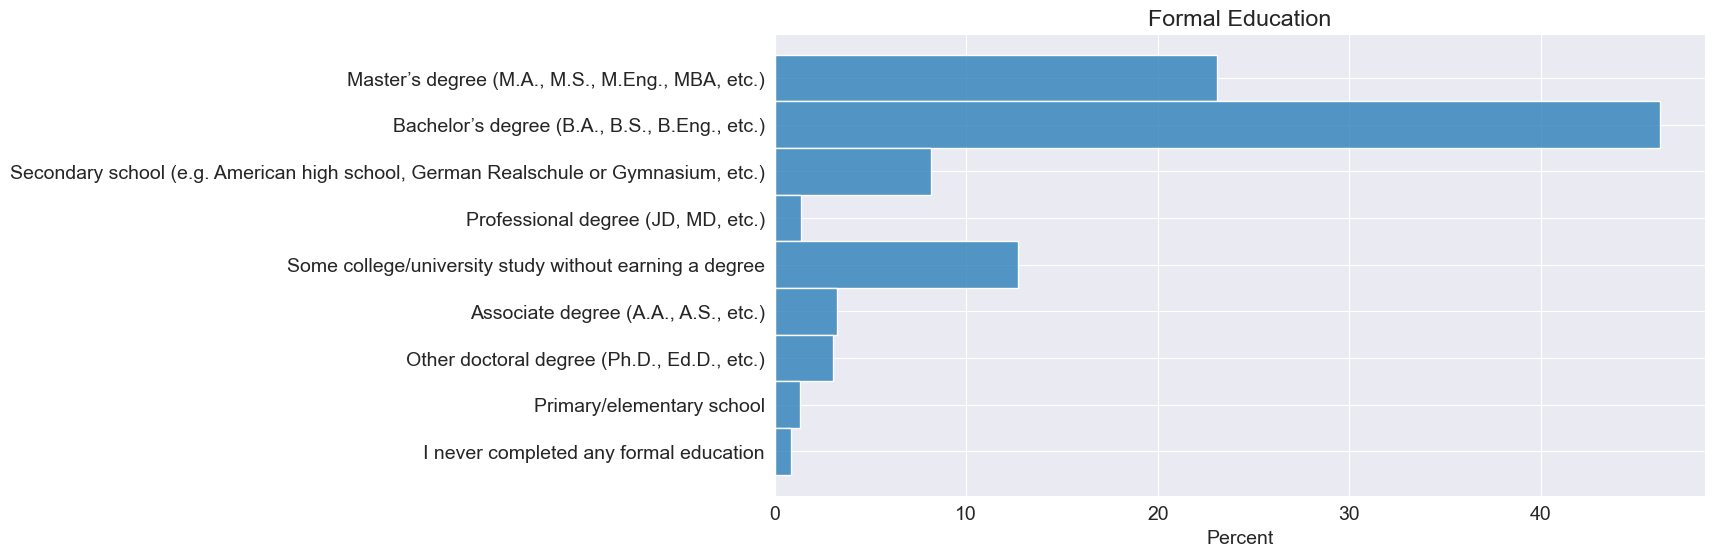

In [23]:
plt.figure(figsize=(12,6))
sns.histplot(y=data.EdLevel, stat='percent')
plt.title('Formal Education')
plt.ylabel(None);

It appears that well over half of the respondents hold a bachelor's or master's degree, so most programmers seem to have some college education. However, it's not clear from this graph alone if they hold a degree in computer science.

In [24]:
data['EdLevel'].value_counts(dropna=False)

Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          25492
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       12716
NaN                                                                                    7203
Some college/university study without earning a degree                                 7010
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     4499
Associate degree (A.A., A.S., etc.)                                                    1797
Other doctoral degree (Ph.D., Ed.D., etc.)                                             1663
Professional degree (JD, MD, etc.)                                                      761
Primary/elementary school                                                               724
I never completed any formal education                                                  460
Name: EdLevel, dtype: int64

In [25]:
degree_options = ['Master’s degree (M.A., M.S., M.Eng., MBA, etc.)', 'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
'Professional degree (JD, MD, etc.)', 'Associate degree (A.A., A.S., etc.)', 'Other doctoral degree (Ph.D., Ed.D., etc.)']
data['degree'] = data['EdLevel'].apply(lambda x: 1 if x  in degree_options else(x if x!=x else 0))
data['degree'].value_counts(dropna=False);

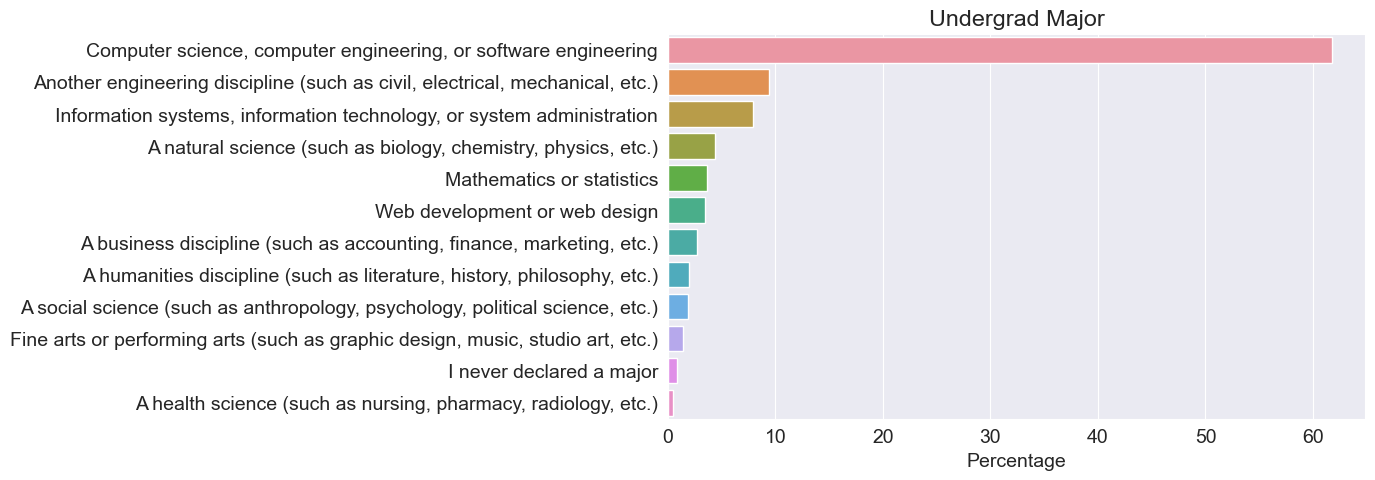

In [26]:
undergrad_pct = data.UndergradMajor.value_counts() * 100 / data.UndergradMajor.count()

sns.barplot(x = undergrad_pct, y = undergrad_pct.index)
plt.title('Undergrad Major')
plt.ylabel(None)
plt.xlabel('Percentage');

It turns out that 40% of programmers holding a college degree have a field of study other than computer science. 

In [27]:
schema_raw.NEWEdImpt

'How important is a formal education, such as a university degree in computer science, to your career?'

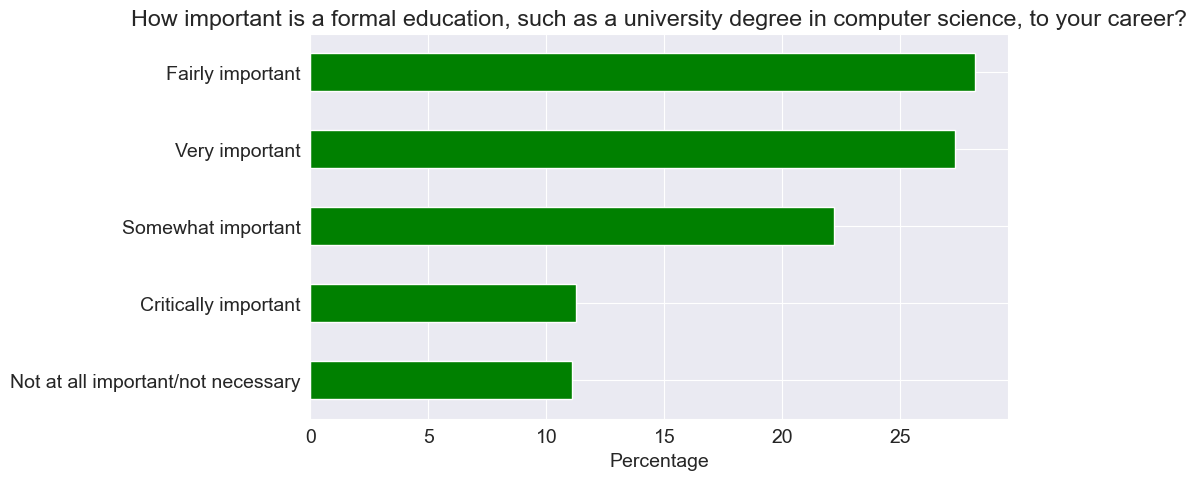

In [28]:
(data.NEWEdImpt.where(data['degree'] == 1).value_counts(normalize=True, ascending=True)*100).plot(kind='barh', color='g')
plt.title('How important is a formal education, such as a university degree in computer science, to your career?')
plt.xlabel('Percentage');


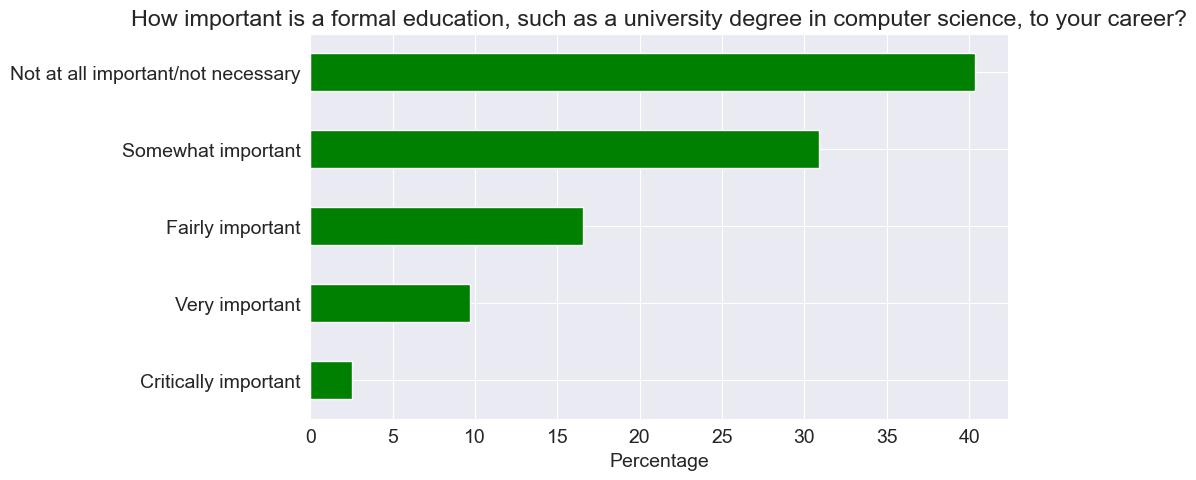

In [29]:
(data.NEWEdImpt.where(data['degree'] == 0).value_counts(normalize=True, ascending=True)*100).plot(kind='barh', color='g')
plt.title('How important is a formal education, such as a university degree in computer science, to your career?')
plt.xlabel('Percentage');

People with degree put more positive on education being important.

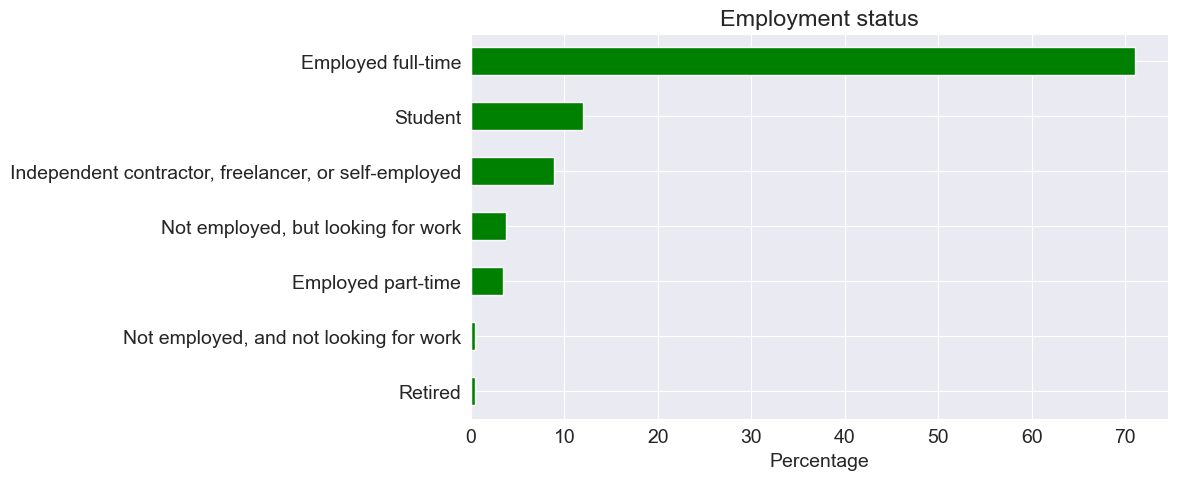

In [30]:
(data.Employment.value_counts(normalize=True, ascending=True)*100).plot(kind='barh', color='g')
plt.title('Employment status')
plt.xlabel('Percentage');

Almost 10% surveyed are contractors, freelancer or self-employed.

In [31]:
def split_multicolumn(col_series):
    result_df = col_series.to_frame()
    options = []
    for idx, value  in col_series[col_series.notnull()].items():
        # Break each value into list of options
        for option in value.split(';'):
            # Add the option as a column 
            if not option in result_df.columns:
                options.append(option)
                result_df[option] = False

            result_df.at[idx, option] = True
    return result_df[options]

dev_type = split_multicolumn(data['DevType'])
dev_type[:5]

,"Developer, desktop or enterprise applications","Developer, full-stack","Developer, mobile",Designer,"Developer, front-end","Developer, back-end","Developer, QA or test",DevOps specialist,"Developer, game or graphics",Database administrator,...,System administrator,Engineering manager,Product manager,Data or business analyst,Academic researcher,Data scientist or machine learning specialist,Scientist,Senior executive/VP,"Engineer, site reliability",Marketing or sales professional
Respondent,,,,,,,,,,,,,,,,,,,,,
1,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [32]:
data = pd.merge(data, dev_type, on='Respondent')

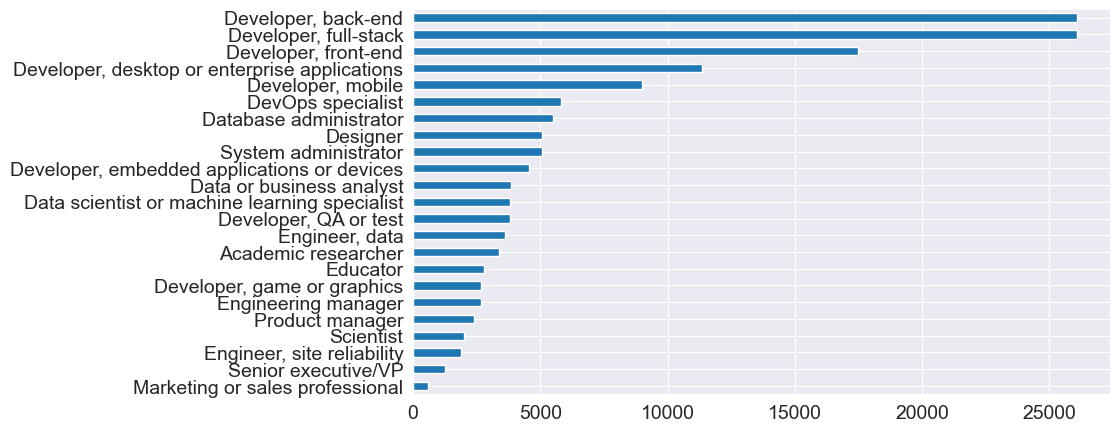

In [69]:
dev_type.sum().sort_values(ascending=True).plot(kind='barh')
plt.xticks();

There is variety but majority of respondents are web developers.

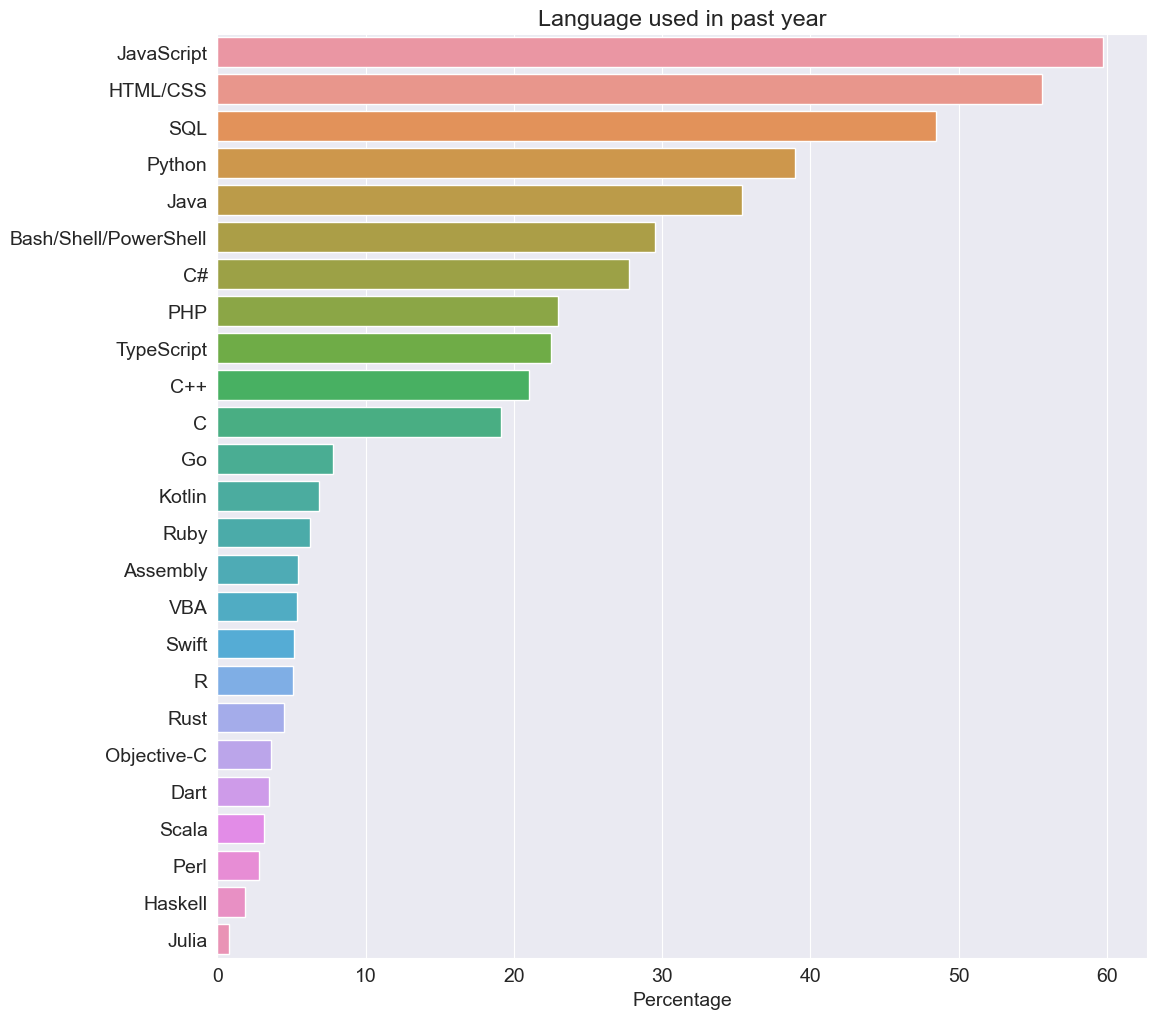

In [35]:
languages_worked = split_multicolumn(data.LanguageWorkedWith)
languages_worked_percentages = languages_worked.mean().sort_values(ascending=False) * 100
plt.figure(figsize=(12,12))
sns.barplot(x=languages_worked_percentages, y=languages_worked_percentages.index)
plt.title('Language used in past year')
plt.xlabel('Percentage');

Perhaps unsurprisingly, Javascript and HTML/CSS comes out at the top as most respondent's are web developers. 

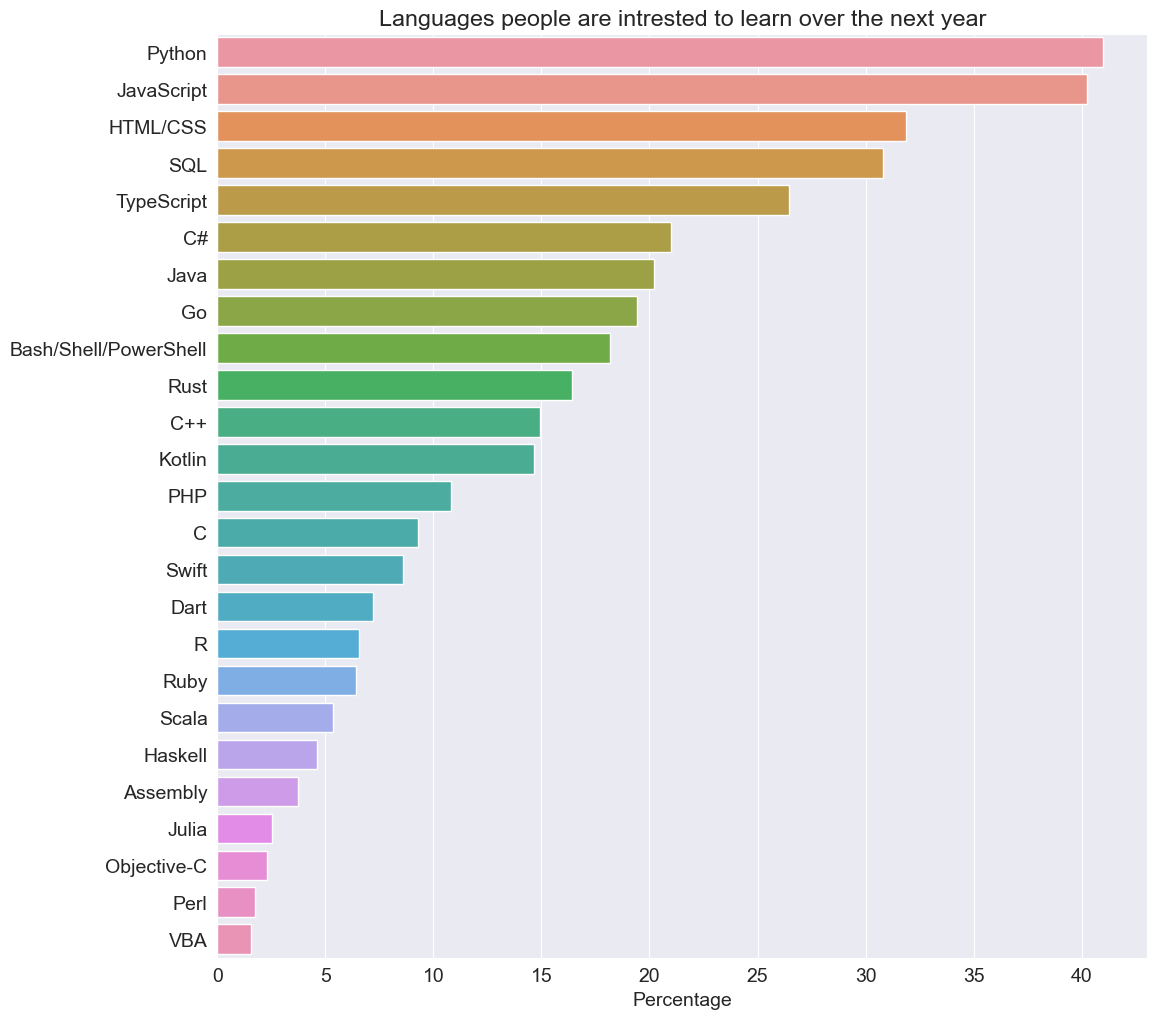

In [36]:
languages_intrested = split_multicolumn(data.LanguageDesireNextYear)
languages_intrested_percentages = languages_intrested.mean().sort_values(ascending=False) * 100
plt.figure(figsize=(12,12))
sns.barplot(x=languages_intrested_percentages, y=languages_intrested_percentages.index)
plt.title('Languages people are intrested to learn over the next year')
plt.xlabel('Percentage');

Makes sense python is top, because it's easy to learn, general-purpose programing language with massive worldwide community, but at the same time it isnt best for web dev which majority of respondents do.

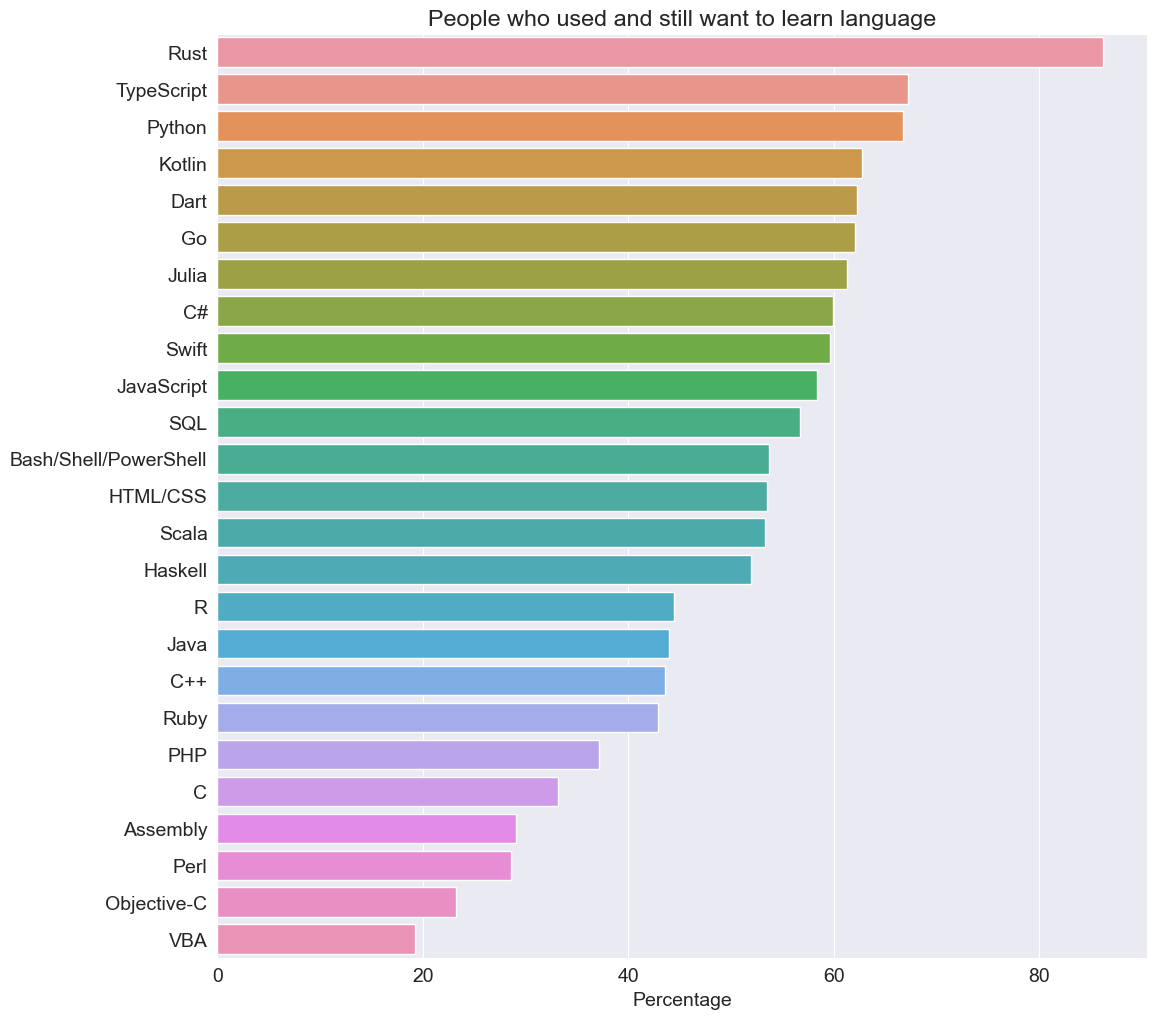

In [41]:
languages_same = languages_worked & languages_intrested
languages_same_percentages = (languages_same.sum() * 100/ languages_worked.sum()).sort_values(ascending=False)
plt.figure(figsize=(12,12))
sns.barplot(x=languages_same_percentages, y=languages_same_percentages.index)
plt.title('People who used and still want to learn language')
plt.xlabel('Percentage');

Not many survey used rust and kotlin, but those who did seem to like it.

In [38]:
mask = data['Country'].value_counts()
data[data['Country'].isin(mask.index[mask>250])].groupby('Country')['WorkWeekHrs'].mean().sort_values(ascending=False)

Country
Iran                  46.405594
Sri Lanka             45.390625
Israel                44.946602
Bangladesh            44.399038
India                 44.328140
Nigeria               43.805031
China                 43.679104
Pakistan              43.588732
Viet Nam              43.433628
Turkey                42.723005
South Africa          42.559816
Kenya                 42.548780
Mexico                42.252366
Greece                42.191235
Indonesia             42.156977
United States         41.993687
Philippines           41.463068
Colombia              41.417647
Japan                 41.369231
Serbia                41.306630
Egypt                 41.136792
Brazil                40.901717
Italy                 40.891247
Portugal              40.843023
Belgium               40.760125
Hungary               40.703065
Russian Federation    40.601418
New Zealand           40.598770
Romania               40.580808
Ukraine               40.390805
Canada                40.385642


There seems to be disparity in working hours, but average is about 40 hours.

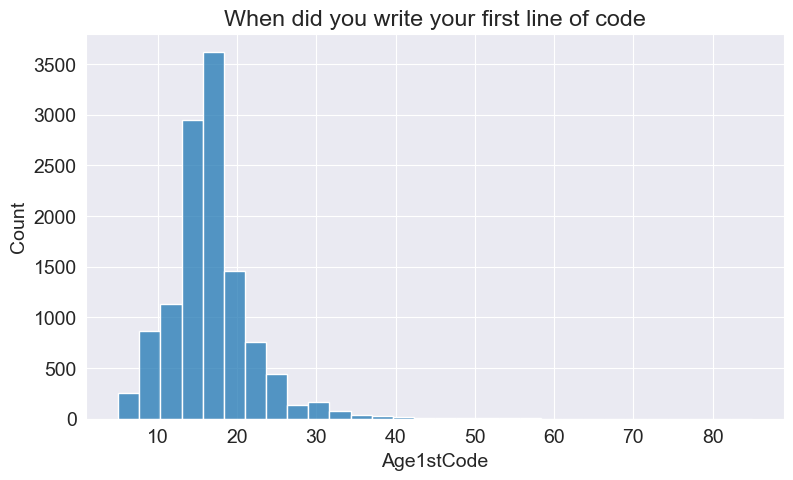

In [54]:
plt.title('When did you write your first line of code')
sns.histplot(x=data[data.Hobbyist == 'No'].Age1stCode, bins=30);

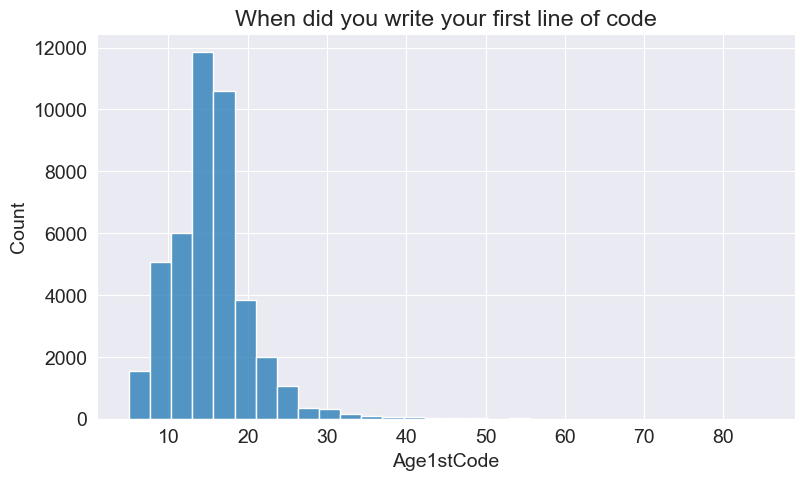

In [67]:
plt.title('When did you write your first line of code')
sns.histplot(x=data[data.Hobbyist == 'Yes'].Age1stCode, bins=30);

Suprisingly hobbyist wrote their first code earlier in life.